In [21]:
import numpy as np
import matplotlib.pyplot as plt

#bounds 
global size
size = 40
lower_bounds = (-size,-size)  #xy bottom left
upper_bounds = (size,size)  #xy top right

lower_bounds_v = (-10,-10)  #xy bottom left
upper_bounds_v = (10,10)  #xy top right

global avoidance_range, flocking_range
aligning_range = 20
flocking_range = 20

 
def gen_points(lower_bounds,upper_bounds,N):
    p = np.random.random_sample((N, 2))
    bottom = np.array([np.array(lower_bounds)]*N)
    diff = np.array([np.array(upper_bounds)-np.array(lower_bounds)]*N)

    points = p*diff+bottom
    
    return points
def multiply_positions_by_scalars(positions,scalars):
    return np.transpose(np.transpose(positions)*np.transpose(scalars))     
global N
N = 200
def heading(v):
    v_mag = np.linalg.norm(v,axis=1)
    h = np.transpose(np.transpose(v)/np.transpose(v_mag))
    return h
x = gen_points(lower_bounds, upper_bounds, N)
v = gen_points(lower_bounds_v, upper_bounds_v, N)

h = heading(v)
M = np.mean(x,axis=0)

def plot_boids(points,center):
    center = (0,0)  #comment out if want to follow flock
    zoom = 3
    b = np.abs(np.transpose(points))
    x_max  = max(b[0])
    y_max  = max(b[1])
    
    x_max  = 30
    y_max  = 30
    scale=x_max*y_max
    
    plt.scatter([boid[0] for boid in points],[boid[1] for boid in points],s=2000/scale)

    plt.xlim(center[0]-zoom*x_max,center[0]+zoom*x_max)
    plt.ylim(center[1]-zoom*y_max,center[1]+zoom*y_max)
    plt.show()
    
def center_of_flock(points):
    center = np.mean(x,axis=0)
    return center


    
def calc_distances(points):
    all_distances = []
    for boid in points:
        k = boid-points
        distances = np.linalg.norm(k,axis=1)
        all_distances.append(distances)
    all_distances = np.array(all_distances)
    return all_distances
distances = calc_distances(x)

def within(distances,tol):
    if distances >= tol: return 0
    if distances < tol: return 1
    
is_within_range = np.vectorize(within)

def calc_local_center(points,local_flocking):
    local_points = np.array([multiply_positions_by_scalars(points, loc) for loc in local_flocking])
    local_points = np.array([multiply_positions_by_scalars(points, loc) for loc in local_flocking])
    number_of_local_points = sum(i > 0 for i in local_flocking)
    local_centers = multiply_positions_by_scalars(np.sum(local_points,axis=1),1/number_of_local_points)  #divide by number of non zeros
    return local_centers



def calc_local_average_headings(local,headings):
    return np.array([np.mean(multiply_positions_by_scalars(headings,l),axis=0) for l in local])

def calc_vectors(points):
    all_vectors = []
    for boid in points:
        k = boid-points
        all_vectors.append(k)
    all_vectors = np.array(all_vectors)
    return all_vectors

def avoidance_function(distance):   #this could be 1/d^2 etc
    if distance > 0:
        return 2/distance
    if distance== 0:
        return 0.0

avoidance_function_vectorized = np.vectorize(avoidance_function)
#fs = avoidance_function_vectorized(distances)
def calc_avoidance_velocity(distances,all_vectors):
    mean_vectors = []
    factors = avoidance_function_vectorized(distances)
    i = 0
    for vectors in all_vectors:
        fs = avoidance_function_vectorized(distances)
        weighted_vectors = multiply_positions_by_scalars(vectors, factors[i])
        mean_vector = np.mean(weighted_vectors,axis=0)
        mean_vectors.append(mean_vector)
        i = i+1
    mean_vectors = np.array(mean_vectors)
    return mean_vectors


def group_center_velocity(points,center):
    global inspect1, inspect2, inspect3, inspect4
    local_flocking = is_within_range(distances,flocking_range)
    local_center=calc_local_center(points, local_flocking)
    towards = local_center - points
    normalised_towards = multiply_positions_by_scalars(towards, 1/(np.linalg.norm(towards,axis=1))**0.5)
    normalised_towards = np.nan_to_num(normalised_towards, copy=True, nan=0.0, posinf=None, neginf=None)
    towards_velocity = normalised_towards*0.5
    return towards_velocity
    
def origin_center_velocity(points):
    towards = np.array([0,0]) - points
    normalised_towards = multiply_positions_by_scalars(towards, 1/(np.linalg.norm(towards,axis=1))**0.5)
    towards_velocity = normalised_towards*0.5
    return towards_velocity

#boids should go to group center, avoid other boids, align headings
def velocity_function(local_average_headings,avoidance_velocities,towards_velocity,towards_origin_velocity):

    v = 2*local_average_headings + 1*avoidance_velocities + 1*towards_velocity + 1*towards_origin_velocity
    
    v_random_variation = gen_points((-1,-1),(1,1),len(v))
    v = v + 0.1*v_random_variation
    v_mag = np.linalg.norm(v,axis=1)
    v_normalised = multiply_positions_by_scalars(v, 1/v_mag) 
    final_v = v_normalised*1
    return final_v
    
def calc_required_params(points,velocities):
    distances = calc_distances(points)
    local2 = is_within_range(distances,aligning_range)
    headings = heading(velocities)
    all_vectors = calc_vectors(points)
    center = center_of_flock(points)
    
    local_average_headings = calc_local_average_headings(local2, headings)
    avoidance_velocities = calc_avoidance_velocity(distances,all_vectors)
    towards_velocity = group_center_velocity(points,center) 
    towards_origin_velocity = 0.2*origin_center_velocity(points)
    return local_average_headings,avoidance_velocities,towards_velocity, towards_origin_velocity




<function matplotlib.pyplot.show(close=None, block=None)>

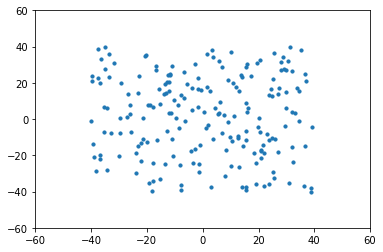

In [22]:
x_vals = [p[0] for p in x]
y_vals = [p[1] for p in x]
scat = plt.scatter(x_vals,y_vals,s=10)
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.show

In [ ]:
dt = 0.1
global x
x = gen_points(lower_bounds, upper_bounds, N)
v = gen_points(lower_bounds_v, upper_bounds_v, N)


def run_sim(x,v):
    x_history = []
    d = 0
    for t in range(0,1000):
        x =  x + v*dt
        local_average_headings,avoidance_velocities,towards_velocity, towards_origin_velocity = calc_required_params(x,v)
        v = 0.95*v + velocity_function(local_average_headings, avoidance_velocities, towards_velocity, towards_origin_velocity)
        #v_mag = np.linalg.norm(v,axis=1)
        #v = multiply_positions_by_scalars(v, 1/v_mag)*15 
        x_history.append(x)
    return x_history


x_history = run_sim(x,v)


def update_scatter(frames):
    scat.set_offsets(x_history[frames])

In [ ]:
import matplotlib.animation as animation 
from IPython.display import HTML
anim = animation.FuncAnimation(scat.figure,
                               update_scatter,
                               frames=1000,
                               interval=50)

anim
HTML(anim.to_jshtml())

In [ ]:
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

anim